#### Workshop Week 5 - Brief intro to data visualization
If you want tips on what types of visualizations to use and when, check out Brezina chapter 1

In [77]:
%pip install seaborn
%pip install numpy pandas
%pip install lxml
%pip install wordcloud
%pip install networkx


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


First, we'll take a look back at tfidf and week 6. We can use the same code to generate tfidf scores, then make a headmap of those scores.

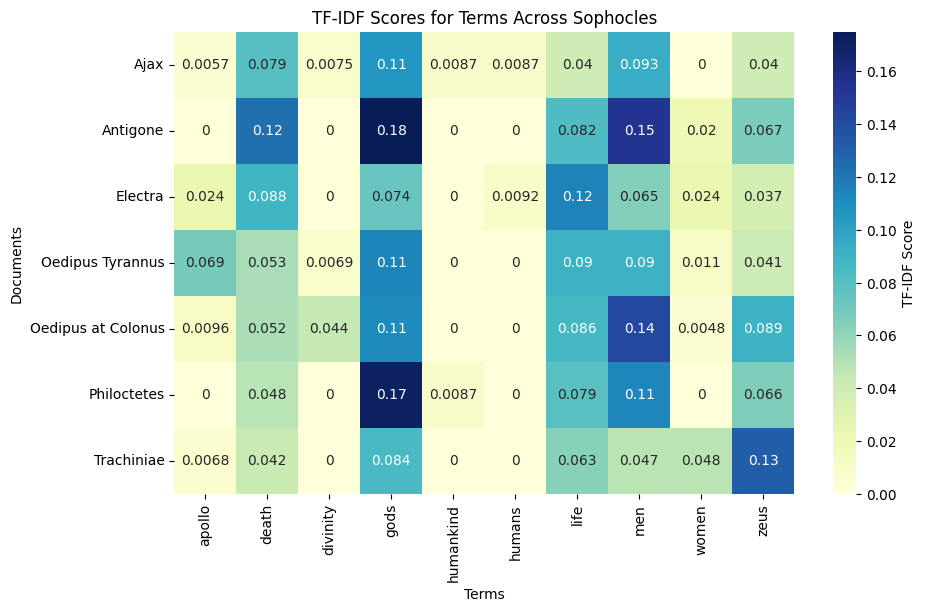

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

df = pd.read_pickle("./greek-tragedy-by-line.pickle")

df.sort_values(by=["title", "n"])
docs = df.groupby(['dramatist', 'title'])['text'].apply(' '.join).reset_index()

sophocles_docs = docs[docs['dramatist'] == 'Sophocles']

vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(sophocles_docs['text'])

tfidf_df = pd.DataFrame(
    X.toarray(),
    index=sophocles_docs['title'],
    columns=vectorizer.get_feature_names_out(),
)

keywords = [
    "apollo",
    "death", 
    "divinity",
    "gods",
    "humankind",
    "humans",
    "life",
    "men",
    "women",
    "zeus"
]

plt.figure(figsize=(10, 6))
sns.heatmap(tfidf_df[keywords], annot=True, cmap="YlGnBu", cbar_kws={'label': 'TF-IDF Score'})
plt.title("TF-IDF Scores for Terms Across Sophocles")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.show()

Of course, simple bar graphs are also always useful. Even if they might be a little bit of a simple way to represent data for this class, where we're often dealing with more complex values that aren't easily represented in bar graph form, they can be a good way to help you initially understand your corpus. 

/tmp/ipykernel_5524/3583650450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sophocles_docs["god_count"] = sophocles_docs["text"].str.count(r'\bgod\b') + sophocles_docs["text"].str.count(r'\bgods\b')


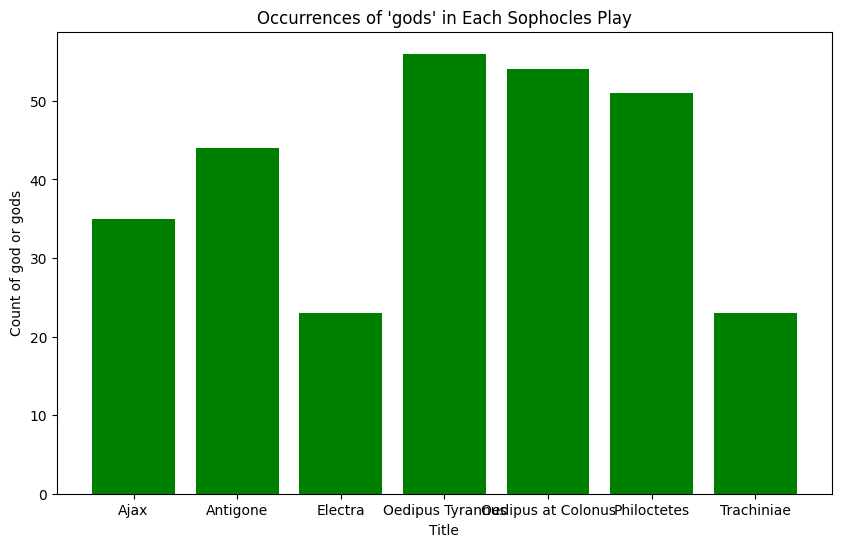

In [79]:
sophocles_docs["god_count"] = sophocles_docs["text"].str.count(r'\bgod\b') + sophocles_docs["text"].str.count(r'\bgods\b')

plt.figure(figsize=(10, 6))
plt.bar(sophocles_docs['title'], sophocles_docs['god_count'], color='green')
plt.xlabel("Title")
plt.ylabel("Count of god or gods")
plt.title("Occurrences of 'gods' in Each Sophocles Play")
plt.show()

Scatterplots can help you understand the relationships between different values. 

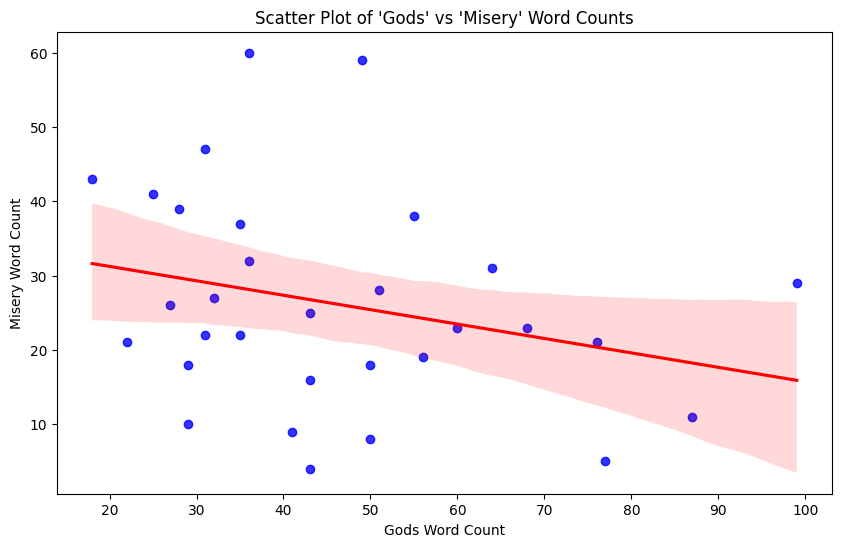

In [80]:
import re
gods_words = ['god', 'gods', 'divine', 'divinity', 'goddess', 'goddesses']
misery_words = ['misery', 'sadness', 'sorrow', 'grief', 'despair', 'mourning', 'woe', 'bitter']

def count_words(text, word_list):
    text = re.sub(r'[^\w\s]', '', text.lower())
    count = sum(1 for word in text.split() if word in word_list)
    return count

word_counts = []
for text in docs['text']:
    gods_count = count_words(text, gods_words)
    misery_count = count_words(text, misery_words)
    word_counts.append((gods_count, misery_count))

counts_df = pd.DataFrame(word_counts, columns=['gods', 'misery'])

plt.figure(figsize=(10, 6))
sns.regplot(x='gods', y='misery', data=counts_df, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title("Scatter Plot of 'Gods' vs 'Misery' Word Counts")
plt.xlabel("Gods Word Count")
plt.ylabel("Misery Word Count")
plt.show()


WordClouds are tbh just kinda fun, and are another way to get an initial understanding of your corpus.

/tmp/ipykernel_5524/534031628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sophocles_docs["length"] = sophocles_docs["text"].apply(len)


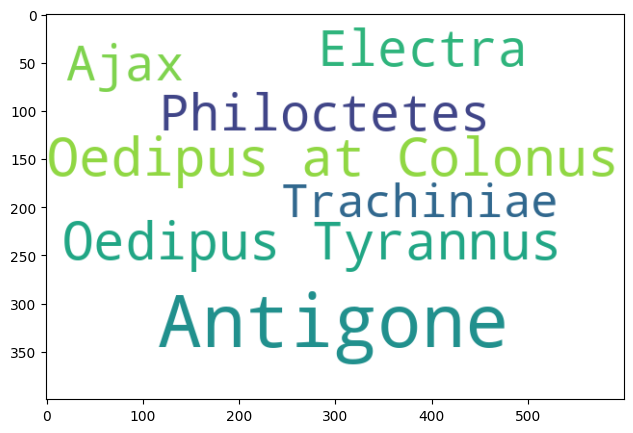

In [81]:
from wordcloud import WordCloud

sophocles_docs["length"] = sophocles_docs["text"].apply(len)

word_freq_dict = dict(zip(sophocles_docs["title"], sophocles_docs["length"]))

wordcloud = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

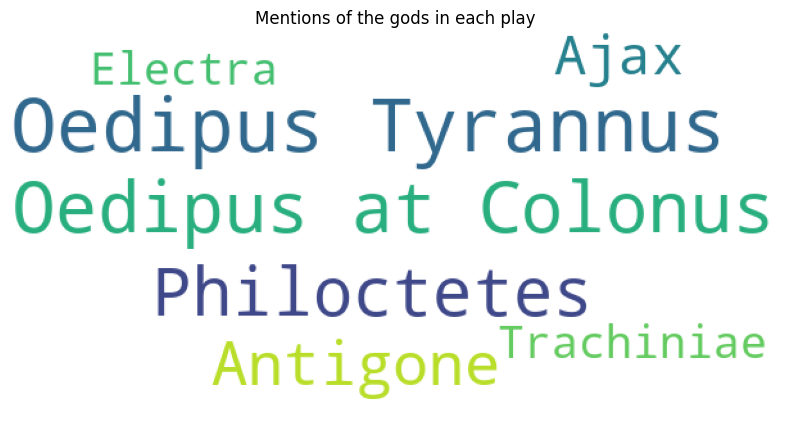

In [82]:
from wordcloud import WordCloud

word_freq_dict = dict(zip(sophocles_docs["title"], sophocles_docs["god_count"]))

wordcloud = WordCloud(width=600, height=300, background_color="white").generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
#you can also remove axes and add a title
plt.axis("off") 
plt.title("Mentions of the gods in each play")
plt.show()

Finally, let's see how you'd build a collocation graph

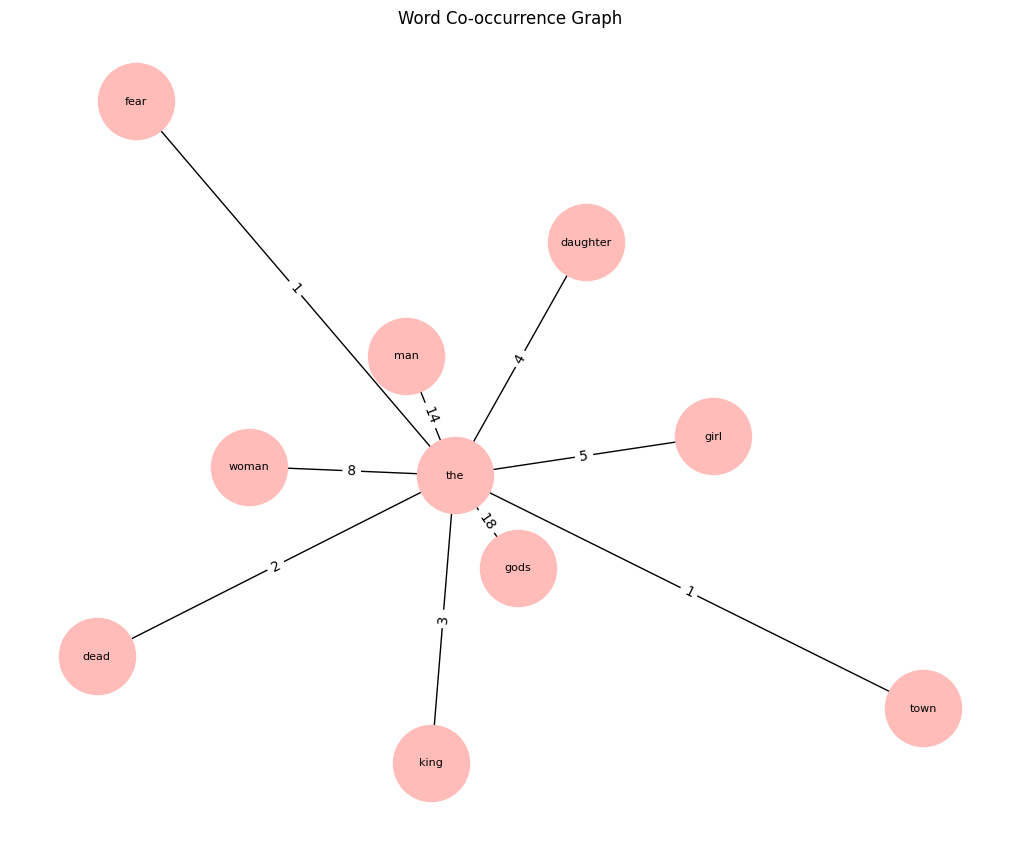

In [83]:
import networkx as nx

def count_ngram_collocations(x, w1, w2, l_size: int = 1, r_size: int = 1):
    indexes = [i for i, word in enumerate(x) if word == w1]

    cooccurrences = 0

    for i in indexes:
        left = max(i - l_size, 0)
        right = min(i + r_size + 1, len(x))

        window = x[left:right]

        if w2 in window:
            cooccurrences += 1
            
    return cooccurrences

antigone_text = df[df["title"] == "Antigone"]["text"]
antigone = re.sub(r'[^\w\s]', '', text.lower()).split()

collocates = ["temple", "girl", "gods", "sister", "brother", "king", "daughter", "man", "woman", "fear", "burial", "town", "dead"]
window_size = 3
edges = []

for collocate in collocates:
    edges.append(("the", collocate, count_ngram_collocations(antigone, "the", collocate, window_size, window_size)))

G = nx.Graph()

for edge in edges:
    if edge[2] != 0:
       G.add_edge(edge[0], edge[1], weight=edge[2])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='#ffbcb8', font_size=8)
edges = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges)
plt.title("Word Co-occurrence Graph")
plt.show()